# MultiScale Layers

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
import pytorch_lightning as pl
from torchvision import transforms
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from rbig_jax.data import GenericDataset

In [30]:
from pl_bolts.datamodules import CIFAR10DataModule

dm = CIFAR10DataModule(os.getcwd(),)

In [12]:
from torchvision.datasets import CIFAR10

In [38]:
%%time
dataset = CIFAR10(os.getcwd(), download=True, train=True)

Files already downloaded and verified
CPU times: user 1.23 s, sys: 215 ms, total: 1.44 s
Wall time: 1.45 s


In [4]:
%%time

X_original, y_original = fetch_openml("cifar_10", version=1, return_X_y=True, as_frame=False)

CPU times: user 1min 5s, sys: 640 ms, total: 1min 6s
Wall time: 1min 6s


In [23]:
len(dataset)

50000

In [24]:
from torch.utils.data import DataLoader, random_split

train_ds, val_ds = random_split(dataset, [45000, 5000])

In [37]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FAE146F9310>, 2)

In [47]:
seed = 123
rng = np.random.RandomState(seed)

X = dataset.data.astype(np.float32)


X += rng.rand(*X.shape)
X_train = X / 256.0

data = X_train[:10_000]

data.shape

(10000, 32, 32, 3)

### Image Shapes

In [48]:
from rbig_jax.custom_types import ImageShape

image_shape = ImageShape(C=3, H=32, W=32)

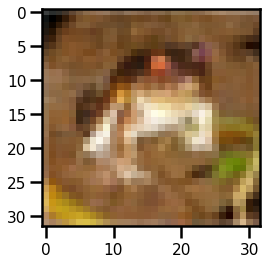

In [49]:
plt.imshow(data[0])

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7fade805f520>)

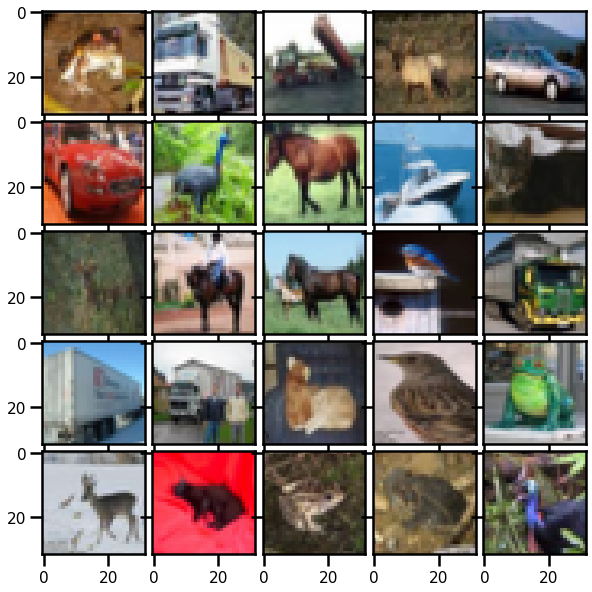

In [50]:
from rbig_jax.plots import plot_image_grid

plot_image_grid(data, None)

## Model Inputs

In [51]:
from rbig_jax.transforms.reshape import flatten_image, unflatten_image

In [52]:
X = flatten_image(data, image_shape, batch=True)
X = jnp.array(X, dtype=jnp.float64)
X.shape

(10000, 3072)

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7fadb91e7070>)

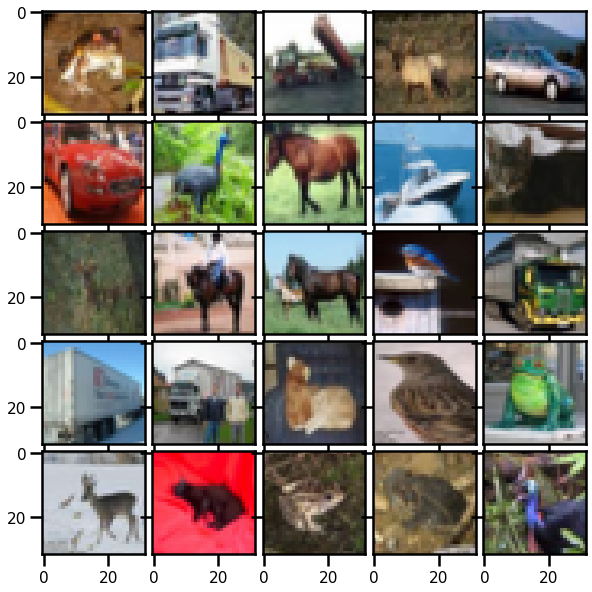

In [53]:
plot_image_grid(X, image_shape)

## Model - Naive (N x D)

### Initialize Layers

In [54]:
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.parametric.householder import InitHouseHolder

In [65]:
# parameters
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)
init_method = "gmm"

init_mixcdf_f = InitMixtureLogisticCDF(
    n_components=n_components, init_method=init_method
)
# init_mixcdf_f = InitMixtureGaussianCDF(
#     n_components=n_components, init_method=init_method
# )

# Logit Transformation
init_logit_f = InitLogitTransform()
# init_logit_f = InitInverseGaussCDF()

# Householder Transformation
n_reflections = 10
method = "random"

# initialize init function
init_hh_f = InitHouseHolder(n_reflections=n_reflections, method=method)

### Initialize Layers with Multiscale

**Scales**

* 1
* 2
* 4
* 8
* 16
* 32

In [67]:
from rbig_jax.transforms.multiscale import MultiScaleBijectorChain
from rbig_jax.transforms.reshape import init_scale_function

In [68]:
rand_idx = jax.random.permutation(key, jnp.arange(100))

In [74]:
jax.random.permutation(rng, X_g)[:5_000].shape

(5000, 3072)

In [92]:
# Layer Params
n_layers = 2
filters = [(2, 2), (4, 4), (8, 8,), (16, 16), (32, 32)]
n_filters = len(filters)

bijectors = []

rng, layer_rngs = jax.random.split(KEY, num=2)

X_g = X[:10_000].copy()
n_sub_samples = 100

# subset data
X_g_subset = jax.random.permutation(rng, X_g)[:n_sub_samples]

# Plotting
plot_layers = False
plot_intermediates = False

if plot_layers:
    plot_image_grid(X_g, image_shape)
#     fig = corner.corner(X_g, color="red", hist_bin_factor=2)

with tqdm.tqdm(filters) as pbar:

    for i_filter in pbar:

        pbar.set_description(
            f"Filter: {i_filter} - Layer: {i} - X: {X_g_subset.shape}- Initializing MixCDF"
        )

        # split keys
        layer_rngs, *ilayer_rngs = jax.random.split(layer_rngs, num=n_layers + 1)
        #         print(len(layer_rings))

        ms_bijectors = []

        ms_reshape = init_scale_function(i_filter, image_shape, batch=False)

        X_g_subset = ms_reshape.forward(X_g_subset)

        for i, irng in enumerate(ilayer_rngs):

            # ======================
            # MIXTURECDF
            # ======================
            # create keys for all inits
            pbar.set_description(
                f"Filter: {i_filter} - Layer: {i} - X: {X_g_subset.shape}- Initializing MixCDF"
            )
            irng, icdf_rng = jax.random.split(irng, 2)

            # intialize bijector and transformation
            X_g_subset, layer = init_mixcdf_f.bijector_and_transform(
                inputs=X_g_subset, rng=icdf_rng, n_features=X_g_subset.shape[1]
            )

            # plot data
            if plot_layers and plot_intermediates:
                fig = corner.corner(X_g_subset, color="red", hist_bin_factor=2)

            # add bijector to list
            ms_bijectors.append(layer)

            # ======================
            # LOGIT
            # ======================
            pbar.set_description(
                f"Filter: {i_filter} - Layer: {i} - X: {X_g_subset.shape}- Logit Transform"
            )
            # intialize bijector and transformation
            X_g_subset, layer = init_logit_f.bijector_and_transform(inputs=X_g_subset)

            ms_bijectors.append(layer)

            # plot data
            if plot_layers and plot_intermediates:
                fig = corner.corner(X_g_subset, color="red", hist_bin_factor=2)

            # ======================
            # HOUSEHOLDER
            # ======================
            pbar.set_description(
                f"Filter: {i_filter} - Layer: {i} - X: {X_g_subset.shape}- HouseHolder"
            )
            # create keys for all inits
            irng, hh_rng = jax.random.split(irng, 2)

            # intialize bijector and transformation
            X_g_subset, layer = init_hh_f.bijector_and_transform(
                inputs=X_g_subset, rng=hh_rng, n_features=X_g_subset.shape[1]
            )
            print(layer.V.shape)

            ms_bijectors.append(layer)

            # plot data
            if plot_layers:
                plot_image_grid(X_g_subset, image_shape)
        #                 fig = corner.corner(X_g, color="red", hist_bin_factor=2)

        # initialize multiscale bijector
        ms_bijector_chain = MultiScaleBijectorChain(
            bijectors=ms_bijectors, filter_shape=i_filter, image_shape=image_shape
        )

        bijectors.append(ms_bijector_chain)

        X_g_subset = ms_reshape.inverse(X_g_subset)

Filter: (2, 2) - Layer: 1 - X: (25600, 12)- Initializing MixCDF:   0%|          | 0/5 [00:07<?, ?it/s]

(10, 12)


Filter: (4, 4) - Layer: 0 - X: (6400, 48)- Initializing MixCDF:  20%|██        | 1/5 [00:14<00:56, 14.04s/it] 

(10, 12)


Filter: (4, 4) - Layer: 1 - X: (6400, 48)- Initializing MixCDF:  20%|██        | 1/5 [00:25<00:56, 14.04s/it]

(10, 48)


Filter: (8, 8) - Layer: 0 - X: (1600, 192)- Initializing MixCDF:  40%|████      | 2/5 [00:36<00:56, 18.86s/it]

(10, 48)


Filter: (8, 8) - Layer: 1 - X: (1600, 192)- Initializing MixCDF:  40%|████      | 2/5 [00:48<00:56, 18.86s/it]

(10, 192)


Filter: (16, 16) - Layer: 0 - X: (400, 768)- Initializing MixCDF:  60%|██████    | 3/5 [01:01<00:43, 21.80s/it] 

(10, 192)


Filter: (16, 16) - Layer: 1 - X: (400, 768)- Initializing MixCDF:  60%|██████    | 3/5 [01:12<00:43, 21.80s/it]

(10, 768)


Filter: (32, 32) - Layer: 0 - X: (100, 3072)- Initializing MixCDF:  80%|████████  | 4/5 [01:23<00:21, 21.92s/it]

(10, 768)


Filter: (32, 32) - Layer: 1 - X: (100, 3072)- Initializing MixCDF:  80%|████████  | 4/5 [01:55<00:21, 21.92s/it]

(10, 3072)


Filter: (32, 32) - Layer: 1 - X: (100, 3072)- HouseHolder: 100%|██████████| 5/5 [02:27<00:00, 29.56s/it]        

(10, 3072)


### GF Model

In [95]:
from rbig_jax.models.gaussflow import GaussianizationFlow
from distrax._src.distributions.normal import Normal

In [96]:
# init base dist
base_dist = Normal(0.0, 1.0)

# init model
gf_model = GaussianizationFlow(bijectors=bijectors, base_dist=base_dist)

#### Forward Transform

In [101]:
%%time

X_trans = gf_model.forward(X[:50])

CPU times: user 8.54 s, sys: 503 ms, total: 9.05 s
Wall time: 3.2 s


In [104]:
X_approx = gf_model.inverse(X_trans)

In [100]:
%%time

X_trans, X_ldj = gf_model.forward_and_log_det(X[:50])

CPU times: user 14.3 s, sys: 1.49 s, total: 15.8 s
Wall time: 4.67 s


In [102]:
X_trans.shape

(50, 3072)

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7face04f1970>)

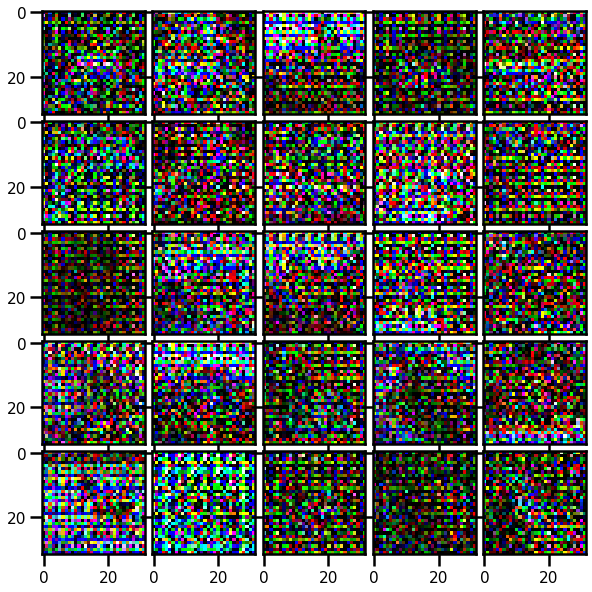

In [103]:
plot_image_grid(X_trans, image_shape)

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7fac8077e400>)

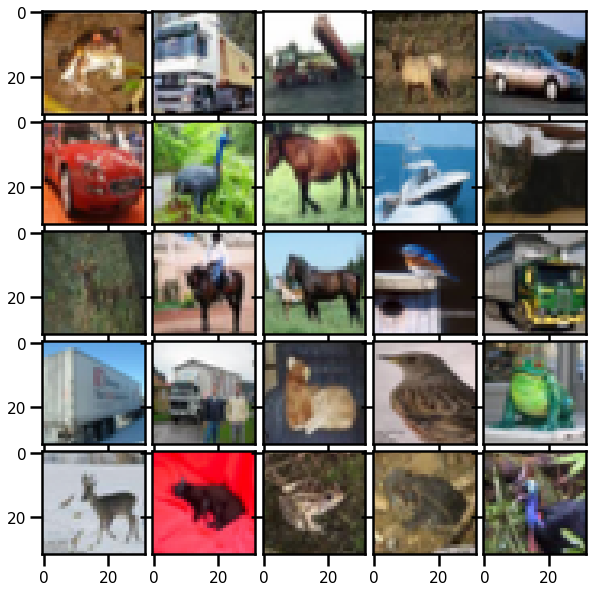

In [105]:
plot_image_grid(X_approx, image_shape)

In [14]:
from rbig_jax.transforms.block import init_default_rbig_block

In [15]:
# X_shape = data.shape[1:]
method = "histogram"
jitted = True

rbig_block_init = init_default_rbig_block(shape=X.shape, method=method, jitted=jitted)

### Forward Transformation

In [16]:
%%time

n_demo = 10_000
X_trans, bijectors = rbig_block_init.forward_and_params(X[:n_demo])
X_trans.shape

CPU times: user 3.03 s, sys: 365 ms, total: 3.39 s
Wall time: 2.05 s


(10000, 3072)

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f9a2c68c040>)

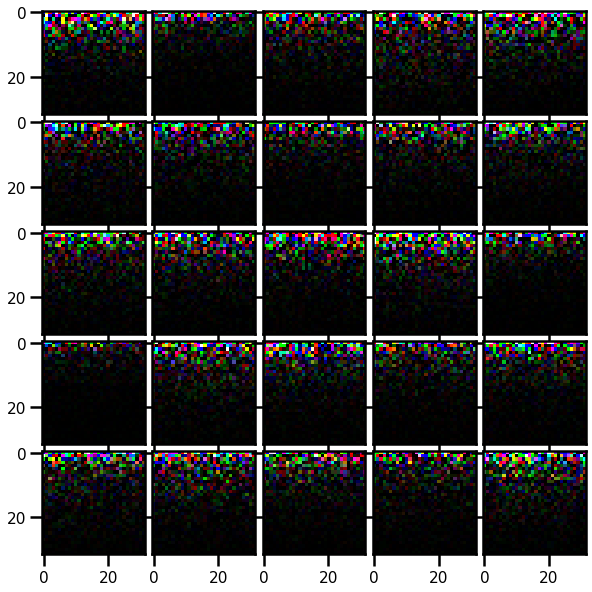

In [18]:
# plot
plot_image_grid(X_trans, image_shape)

### Inverse Transformation

In [19]:
from rbig_jax.transforms.base import BijectorChain

rbig_block = BijectorChain(bijectors=bijectors)

In [21]:
%%time

X_approx = rbig_block.inverse(X_trans)

chex.assert_tree_all_close(X_approx, X[:n_demo])

CPU times: user 40.8 s, sys: 6.37 s, total: 47.2 s
Wall time: 6.77 s


(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f9a205d95b0>)

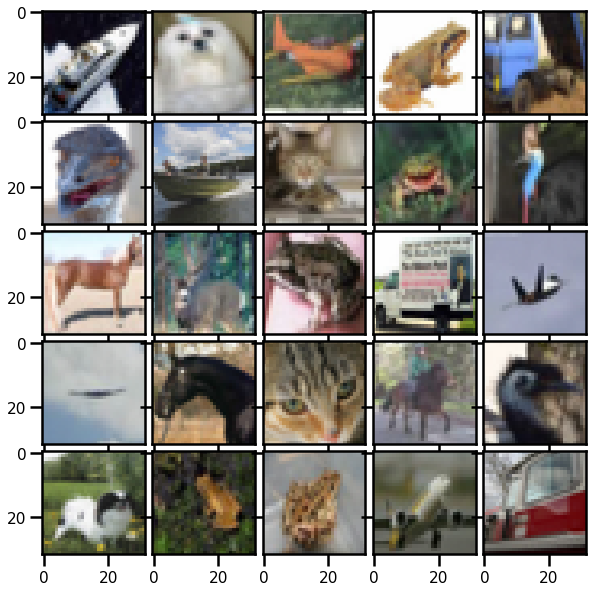

In [23]:
plot_image_grid(X_approx, image_shape)

## MultiScale RBIG Init

### Initialization

In [56]:
from rbig_jax.transforms.multiscale import MultiScaleRBIGBlockInit

# X_shape = data.shape[1:]
method = "histogram"
jitted = True

rbig_block_init = init_default_rbig_block(shape=X.shape, method=method, jitted=jitted)

In [57]:
X[:n_demo].shape

(10000, 3072)

In [40]:
# from rbig_jax.transforms.rotation import compute_projection

# _, _, VT = jnp.linalg.svd(X[:n_demo], full_matrices=True, compute_uv=True)

In [52]:
filter_shape = (4, 4)

# init MS Block
rbig_ms_block_init = MultiScaleRBIGBlockInit(
    init_functions=rbig_block_init.init_functions,
    filter_shape=filter_shape,
    image_shape=image_shape,
)

### Forward & Inverse Transform

In [53]:
%%time

n_demo = 10_000

# forward transformation (with bijector)
X_trans, ms_bijectors = rbig_ms_block_init.forward_and_params(X[:n_demo])

# inverse transformation
X_approx = ms_bijectors.inverse(X_trans)

chex.assert_tree_all_close(X[:n_demo], X_approx)

CPU times: user 47.7 s, sys: 13.4 s, total: 1min 1s
Wall time: 13.3 s


In [60]:
# plot_image_grid(X_trans, image_shape)

### Training

In [73]:
from rbig_jax.training.iterative import train_info_loss_model

# define training params
verbose = True
n_layers_remove = 50
interval = 10

# run iterative training
X_g, rbig_model_info = train_info_loss_model(
    X=X[:n_demo],
    rbig_block_init=rbig_ms_block_init,
    loss=None,
    verbose=verbose,
    interval=interval,
    n_layers_remove=n_layers_remove,
)

Layer 10 - Cum. Info Reduction: 9595.806 - Elapsed Time: 85.6566 secs
Layer 20 - Cum. Info Reduction: 9608.986 - Elapsed Time: 171.2685 secs
Layer 30 - Cum. Info Reduction: 9616.180 - Elapsed Time: 256.8861 secs
Layer 40 - Cum. Info Reduction: 9621.025 - Elapsed Time: 342.8239 secs
Layer 50 - Cum. Info Reduction: 9627.247 - Elapsed Time: 428.3511 secs
Layer 60 - Cum. Info Reduction: 9632.328 - Elapsed Time: 514.3306 secs
Layer 70 - Cum. Info Reduction: 9634.775 - Elapsed Time: 600.3593 secs
Layer 80 - Cum. Info Reduction: 9638.316 - Elapsed Time: 686.2350 secs
Layer 90 - Cum. Info Reduction: 9640.691 - Elapsed Time: 771.8946 secs
Layer 100 - Cum. Info Reduction: 9643.461 - Elapsed Time: 858.0103 secs
Layer 110 - Cum. Info Reduction: 9645.189 - Elapsed Time: 943.8699 secs
Layer 120 - Cum. Info Reduction: 9649.090 - Elapsed Time: 1030.0180 secs
Layer 130 - Cum. Info Reduction: 9651.238 - Elapsed Time: 1115.7478 secs
Layer 140 - Cum. Info Reduction: 9652.765 - Elapsed Time: 1201.9281 secs

### Results

#### Losses

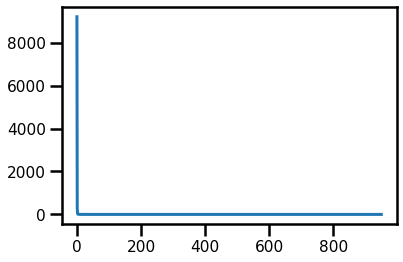

In [76]:
plt.plot(rbig_model_info.info_loss)

#### Latent Space

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f9910432eb0>)

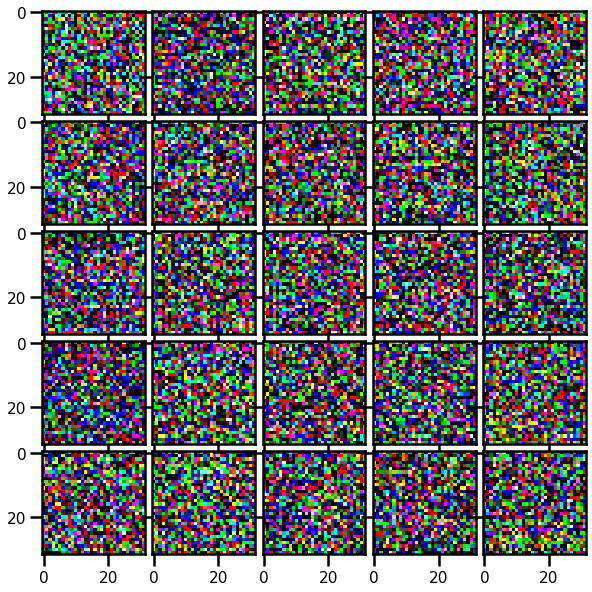

In [77]:
plot_image_grid(X_g, image_shape)

#### Original Space

In [79]:
%%time

n_demo = 10_000

# forward transformation (with bijector)
X_approx = rbig_model_info.inverse_and_log_det(X_g)

AttributeError: 'str' object has no attribute 'inverse_and_log_det'

In [ ]:
plot_image_grid(X_approx, image_shape)

## MultiScale Layer

#### Forward Reshape

1. Factor spatial dimension

* $fh$ - filter height
* $fw$ - filter width

$$
\text{B} \times \text{H} \times \text{W} \times \text{C} \rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw 
$$

2. Transpose

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw 
\rightarrow
\text{B}  \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \times fh \times fw \times \text{C}
$$

3. Aggregate Spatial Dim factors into channels

$$
\text{B} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw  \times \text{C}
\rightarrow
\left( \text{B}  \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \right) \times \left( fh \times fw \times \text{C} \right)
$$

4. (1x1 Parametric)

$$
\text{B} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw  \times \text{C}
\rightarrow
\text{B}  \times   \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}}  \times \left( fh \times fw \times \text{C} \right)
$$


**Striding**! :)

**Dilation**! :)

---

**Test**:

* NonLinearities

In [180]:
# X_ms = rearrange(X, "B (Hn fh) (Wn fw) C -> (B C Hn Wn) (fh fw)", fh=fh, fw=fw)
# new shapes
fh, fw = 2, 2
Hn = img_shape.H // fh
Wn = img_shape.W // fw

X_ms = rearrange(
    X[:10],
    "B (Hn fh Wn fw C) -> (B Hn Wn) (fh fw C)",
    fh=fh,
    fw=fw,
    C=img_shape.C,
    Wn=Wn,
    Hn=Hn,
)
X_ms.shape

(2560, 12)

#### Inverse Reshape



1. Aggregate Spatial Dim factors into channels

$$
\left( \text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \right) \times \left( \text{fh} \times \text{fw} \right)
\rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times \text{fh} \times \frac{\text{W}}{\text{fw}} \times \text{fw} 
$$

2. Transpose

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \times \text{fh} \times \text{fw}
\rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times \text{fh} \times \frac{\text{W}}{\text{fw}} \times \text{fw}
$$

3. Factor spatial dimension

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times \text{fh} \times \frac{\text{W}}{\text{fw}} \times \text{fw} 
\rightarrow
\text{B} \times \text{H} \times \text{W} \times \text{C} 
$$

In [182]:
# X_approx = rearrange(
#     X_ms,
#     "(B C Hn Wn) (fh fw) -> B (Hn fh) (Wn fw) C",
#     B=B,
#     C=C,
#     Hn=Hn,
#     Wn=Wn,
#     fh=fh,
#     fw=fw,
# )
X_approx = rearrange(
    X_ms,
    "(B Hn Wn) (fh fw C) -> B (Hn fh Wn fw C)",
    C=img_shape.C,
    Hn=Hn,
    Wn=Wn,
    fh=fh,
    fw=fw,
)

# assert they're the same
np.testing.assert_array_equal(X_approx, X[:10])

In [59]:
from rbig_jax.custom_types import RescaleParams, ImageShape

In [335]:
from typing import Callable





class RescaleFunctions(NamedTuple):
    forward: Callable
    inverse: Callable
    params: RescaleParams


def init_scale_function(filter, image_shape):

    # create filter params
    fh, fw = filter
    H = img_shape.H
    W = img_shape.W
    C = img_shape.C
    #     # do some checks!
    #     assert H / fh !% 0
    #     assert W / fw !% 0

    Hn = H // fh
    Wn = W // fw

    rescale_params = RescaleParams(fh=fh, fw=fw, H=H, W=W, C=C, Hn=Hn, Wn=Wn)

    def forward(inputs):

        return rearrange(
            inputs,
            "B (Hn fh Wn fw C) -> (B Hn Wn) (fh fw C)",
            fh=fh,
            fw=fw,
            C=C,
            Wn=Wn,
            Hn=Hn,
        )

    def inverse(inputs):

        temp = rearrange(
            inputs,
            "(B Hn Wn) (fh fw C) -> B Hn Wn fh fw C",
            #             B=inputs.shape[0],
            C=C,
            Hn=Hn,
            Wn=Wn,
            fh=fh,
            fw=fw,
        )
        return rearrange(
            temp,
            "B Hn Wn fh fw C -> B (Hn fh Wn fw C)",
            #             B=inputs.shape[0],
            C=C,
            Hn=Hn,
            Wn=Wn,
            fh=fh,
            fw=fw,
        )

    return RescaleFunctions(forward=forward, inverse=inverse, params=rescale_params)

### Scale I 

In [310]:
ms_reshape = init_scale_function((2, 2), img_shape)
img_shape, X.shape

(ImageShape(H=32, W=32, C=3), (5000, 3072))

#### Test - Forward | Inverse

In [320]:
X_ms_l1 = ms_reshape.forward(X[:30])
print(X_ms_l1.shape)
X_ms_l1 = ms_reshape.inverse(X_ms_l1)
print(X_ms_l1.shape)

(7680, 12)
(7680, 12)
(30, 3072)


In [321]:
# reshape
X_ms_l1 = ms_reshape.forward(X[:30])
print(X_ms_l1.shape)

# transformation
X_ms_l1_trans, bijectors = rbig_block_init.forward_and_params(X_ms_l1)

# inverse reshape
X_ms_l1 = ms_reshape.inverse(X_ms_l1_trans)
print(X_ms_l1.shape)

(7680, 12)
(7680, 12)
(30, 3072)


In [425]:
bijectors[0]

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f4ee42c91f0>)

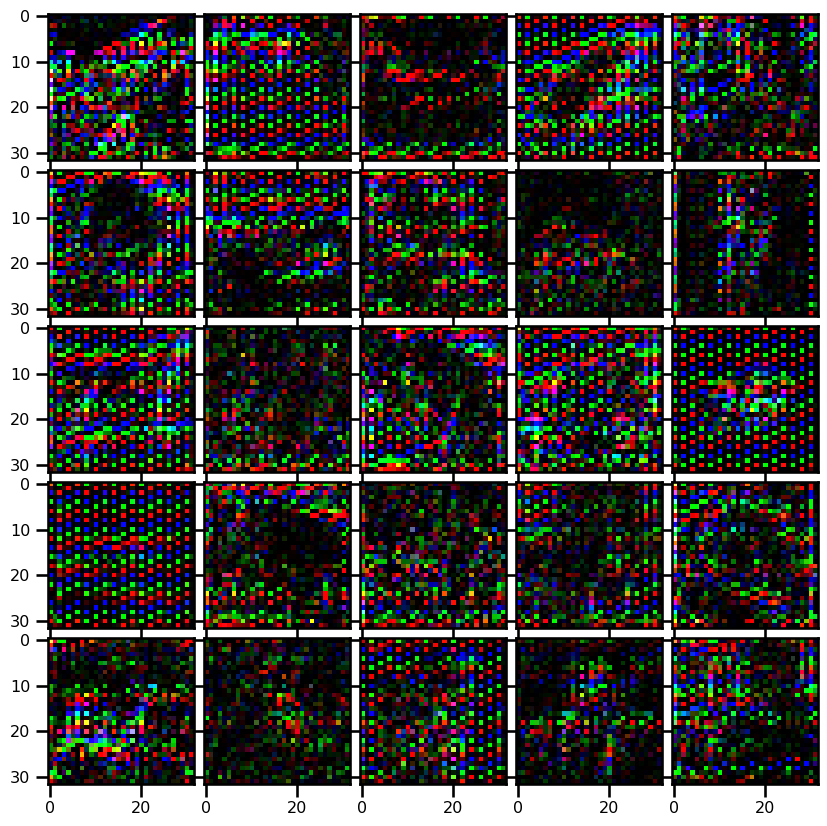

In [322]:
plot_image_grid(X_ms_l1)

## Init Block

In [331]:
from chex import dataclass, Array
from typing import Tuple
from rbig_jax.transforms.block import RBIGBlockInit


@dataclass
class RBIGMSBlockInit:
    rbig_block_init: RBIGBlockInit
    filter_shape: Tuple[int, int]
    image_shape: Tuple

    def __post_init__(self):
        self.ms_reshape = init_scale_function(self.filter_shape, self.image_shape)

    def forward_and_params(self, inputs: Array):

        # rescale data
        inputs = self.ms_reshape.forward(inputs)

        # do forward transformation
        outputs, params = rbig_block_init.forward_and_params(inputs)
        
        # rescale data
        outputs = self.ms_reshape.inverse(outputs)

        return outputs, params

    def forward(self, inputs: Array):

        # rescale data
        inputs = self.ms_reshape.forward(inputs)

        # do forward transformation
        outputs = rbig_block_init.forward(inputs)
        
        # rescale data
        outputs = self.ms_reshape.inverse(outputs)

        return outputs

In [435]:
from rbig_jax.transforms.multiscale import MultiScaleBijectorChain

ImportError: cannot import name 'MultiScaleBijectorChain' from 'rbig_jax.transforms.multiscale' (/home/emmanuel/code/rbig_jax/rbig_jax/transforms/multiscale.py)

In [431]:
from rbig_jax.transforms.reshape import init_scale_function

In [332]:
ms_reshape = init_scale_function((2, 2), img_shape)
img_shape, X.shape

(ImageShape(H=32, W=32, C=3), (5000, 3072))

In [341]:
# parameters
filter_shape = (16, 16)

# initialize block
rbig_msblock_init = RBIGMSBlockInit(
    rbig_block_init=rbig_block_init, filter_shape=filter_shape, image_shape=img_shape
)

In [344]:
X.shape

(5000, 3072)

In [343]:
X_trans, params = rbig_msblock_init.forward_and_params(X[:100])

EinopsError:  Error while processing rearrange-reduction pattern "(B Hn Wn) (fh fw C) -> B Hn Wn fh fw C".
 Input tensor shape: (400, 400). Additional info: {'C': 3, 'Hn': 2, 'Wn': 2, 'fh': 16, 'fw': 16}.
 Shape mismatch, 400 != 768

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f4ee43123d0>)

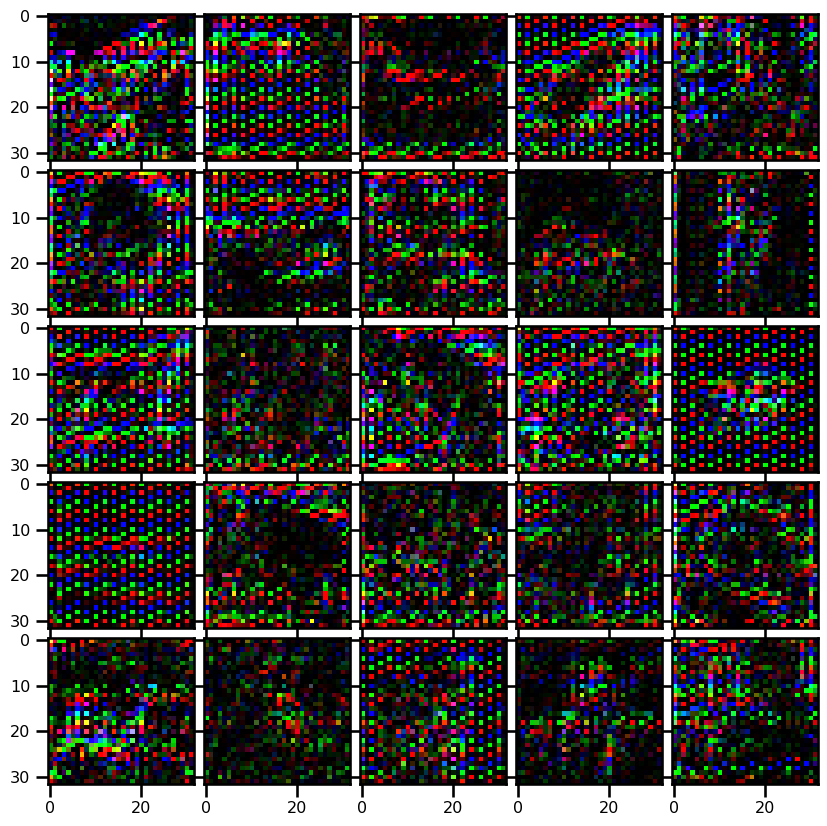

In [338]:
plot_image_grid(X_trans)

In [ ]:
# reshape
X_ms_l1 = ms_reshape.forward(X[:30])
print(X_ms_l1.shape)

# transformation
X_ms_l1_trans, bijectors = rbig_block_init.forward_and_params(X_ms_l1)

# inverse reshape
X_ms_l1 = ms_reshape.inverse(X_ms_l1_trans)
print(X_ms_l1.shape)

### Inverse

In [323]:
from rbig_jax.transforms.base import BijectorChain

rbig_block = BijectorChain(bijectors=bijectors)

In [324]:
X_ms_l1.shape

(30, 3072)

In [325]:
X_approx = ms_reshape.forward(X_ms_l1)
X_approx = rbig_block.inverse(X_approx)
X_approx = ms_reshape.inverse(X_approx)

(7680, 12)


(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f4ee37ae1c0>)

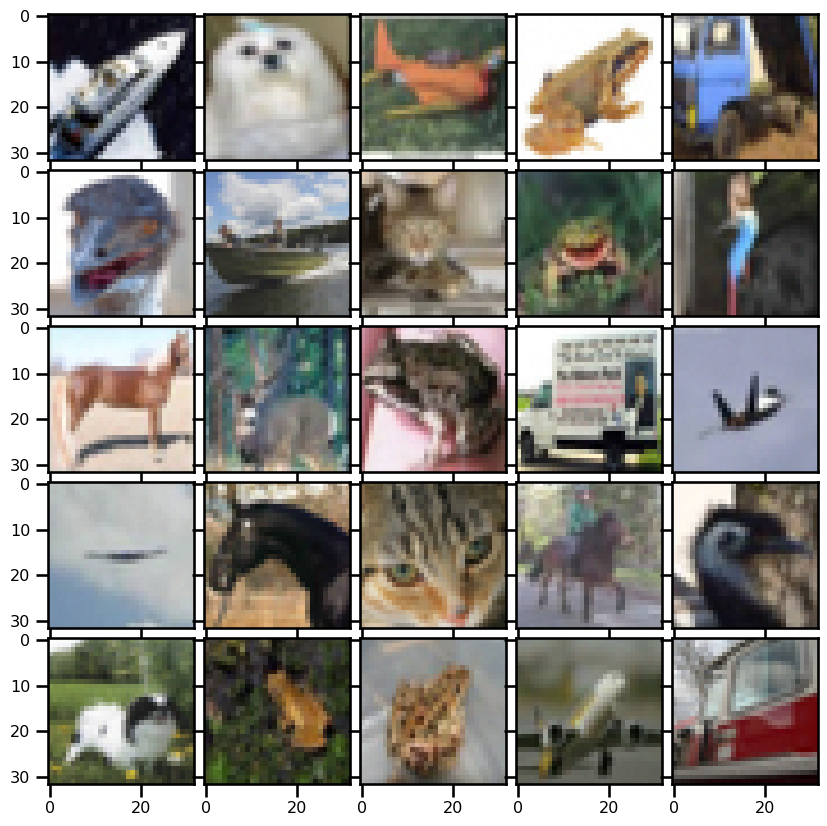

In [326]:
plot_image_grid(X_approx)

In [173]:
X_approx = ms_reshape[1](X_ms_l1)
print(X_approx.shape)
X_approx = rbig_block.inverse(X_approx)
X_approx = ms_reshape[0](X_approx)

EinopsError:  Error while processing rearrange-reduction pattern "(B Hn Wn) (fh fw C) -> B (Hn fh Wn fw C)".
 Input tensor shape: (5000, 3072). Additional info: {'C': 3, 'Hn': 16, 'Wn': 16, 'fh': 2, 'fw': 2}.
 Shape mismatch, can't divide axis of length 5000 in chunks of 256

In [ ]:
plot_image_grid(X_ms_l1)

In [74]:
from chex import Array, dataclass
from typing import Tuple, List

@dataclass
class MultiScaleRBIGBlockInit:
    init_functions: List[dataclass]
    filter = Tuple[int, int]

    def forward(self, inputs: Array) -> Tuple[Array, Array]:
        outputs = inputs
        params = []

        # loop through bijectors
        for ibijector in self.init_functions:

            # transform and params
            outputs, iparams = ibijector.bijector_and_transform(outputs)

            # accumulate params
            params.append(iparams)

        return outputs, params

    def inverse(self, inputs: Array) -> Array:
        outputs = inputs
        for ibijector in self.init_functions:
            outputs = ibijector.transform(outputs)
        return outputs

NameError: name 'List' is not defined

### Layer I - Univariate Histogram

In [5]:
from rbig_jax.transforms.histogram import InitUniHistTransform, init_bin_estimator
from rbig_jax.transforms.kde import InitUniKDETransform, estimate_bw

# histogram params
support_extension = 20
alpha = 1e-5
precision = 1_000
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = True

# KDE specific Transform
bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")

method = "kde"

In [6]:
# initialize histogram transformation
if method == "histogram":

    init_hist_f = InitUniHistTransform(
        n_samples=X.shape[0],
        nbins=nbins,
        support_extension=support_extension,
        precision=precision,
        alpha=alpha,
        jitted=jitted,
    )
elif method == "kde":

    init_hist_f = InitUniKDETransform(
        shape=X.shape, support_extension=support_extension, precision=precision, bw=bw
    )
else:
    raise ValueError(f"Unrecognized transform: {method}")

#### Transformations

Text(0.5, 0.98, 'Gradient Transformation')

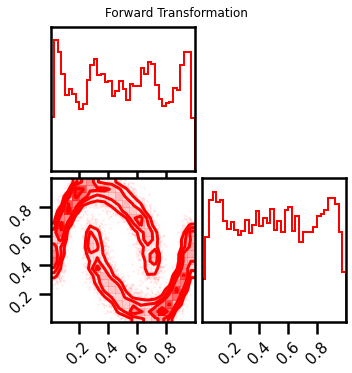

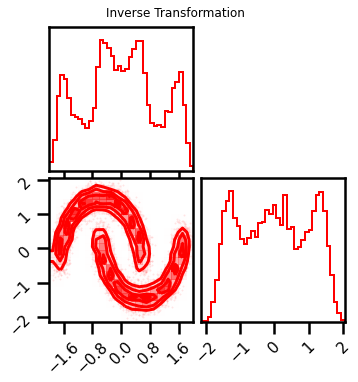

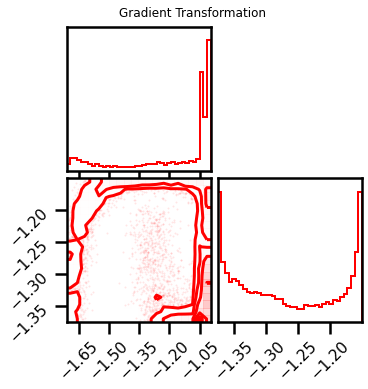

In [7]:
# initialize bijector
X_u, hist_bijector = init_hist_f.bijector_and_transform(X)

# forward transformation
X_l1 = hist_bijector.forward(X)

# inverse transformation
X_approx = hist_bijector.inverse(X_l1)

# gradient transformation
X_l1_ldj = hist_bijector.forward_log_det_jacobian(X_l1)

# plot Transformations
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l1_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

### Layer II - Inverse Gaussian CDF

In [8]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF

# univariate normalization Gaussianization parameters
eps = 1e-5
jitted = True

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDF(eps=eps, jitted=jitted)

#### Transformations

In [9]:
# forward with bijector
X_l2, icdf_bijector = init_icdf_f.bijector_and_transform(X_l1)

# alternatively - forward with no bijector
X_l2_ = icdf_bijector.forward(X_l1)

chex.assert_tree_all_close(X_l2_, X_l2)

# inverse transformation
X_l1_approx = icdf_bijector.inverse(X_l2)
chex.assert_tree_all_close(X_l1_approx, X_l1, rtol=1e-5)

# gradient transformation
X_l2_ldj = icdf_bijector.forward_log_det_jacobian(X_l1)

Text(0.5, 0.98, 'Gradient Transformation')

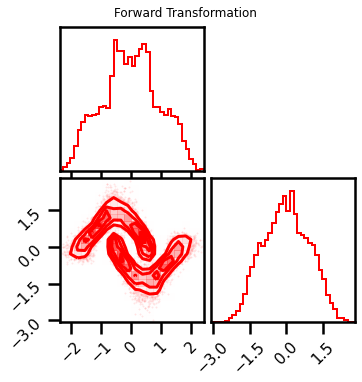

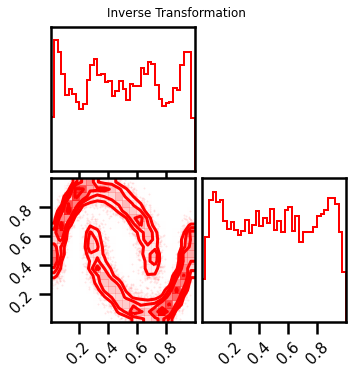

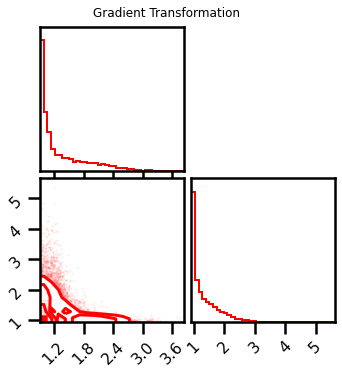

In [10]:
# plot Transformations
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l1_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l2_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

### PCA Transformation

In [11]:
from rbig_jax.transforms.rotation import InitPCARotation

# initialize histogram transformation
init_pca_f = InitPCARotation(jitted=True)

In [12]:
# forward with bijector
X_l3, pca_bijector = init_pca_f.bijector_and_transform(X_l2)

# alternatively - forward with no bijector
X_l3_ = pca_bijector.forward(X_l2)

chex.assert_tree_all_close(X_l3_, X_l3)

# inverse transformation
X_l2_approx = pca_bijector.inverse(X_l3)

chex.assert_tree_all_close(X_l2_approx, X_l2, rtol=1e-3)

# gradient transformation
X_l3_ldj = pca_bijector.forward_log_det_jacobian(X_l2)

chex.assert_tree_all_close(X_l3_ldj, jnp.zeros_like(X_l3_ldj))

Text(0.5, 0.98, 'Inverse Transformation')

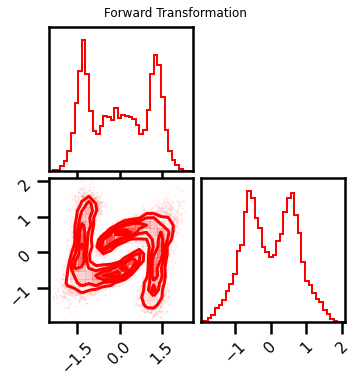

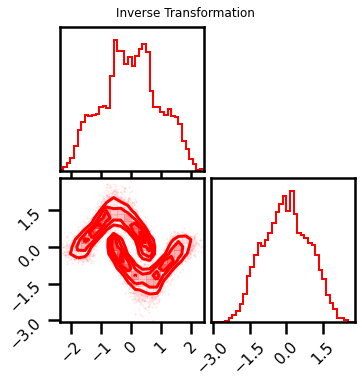

In [13]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l2_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")

## RBIG Blocks

1. Marginal Gaussianization
2. Random Rotation

In [14]:
from rbig_jax.transforms.block import RBIGBlockInit

# create a list of transformations
init_functions = [init_hist_f, init_icdf_f, init_pca_f]

# create an RBIG "block" init
rbig_block_init = RBIGBlockInit(init_functions=init_functions)

In [15]:
# forward and params
X_g, bijectors = rbig_block_init.forward_and_params(X)

# alternatively just the forward
X_g = rbig_block_init.forward(X)

Text(0.5, 0.98, 'Forward Transformation')

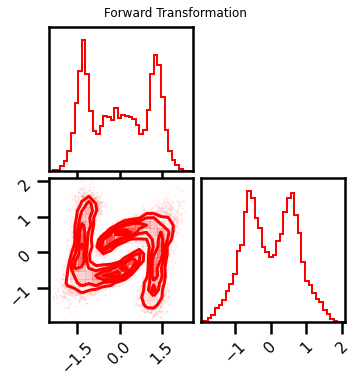

In [16]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")

## Forward and Inverse Transformations

So here we want to be able to chain the transformations together. We have initialized our bijectors but it would be nice to have a convenient way to loop through them calculating all of the quanties, e.g. `forward`, `inverse`, `log_det_jacobian` and some combination of them.

In this package, we have the `BijectorChain` class which gives us that flexibility.

In [17]:
from rbig_jax.transforms.base import BijectorChain
from distrax._src.distributions.normal import Normal

# create a list of BIJECTORS (not init functions)
bijectors = [hist_bijector, icdf_bijector, pca_bijector]

# create rbig_block
rbig_block = BijectorChain(bijectors=bijectors)

In [18]:
# forward with bijector
X_l3 = rbig_block.forward(X)

# inverse transformation
X_approx = rbig_block.inverse(X_l3)

chex.assert_tree_all_close(X_approx, X, rtol=1e-4)

# gradient transformation
X_l3_ldj = rbig_block.forward_log_det_jacobian(X)

# forward and gradient transformation
X_l3_, X_l3_ldj_ = rbig_block.forward_and_log_det(X)

chex.assert_tree_all_close(X_l3_, X_l3)
chex.assert_tree_all_close(X_l3_ldj, X_l3_ldj_)

Text(0.5, 0.98, 'Gradient Transformation')

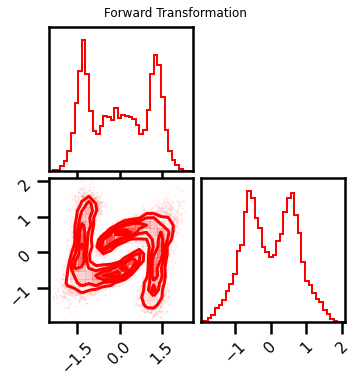

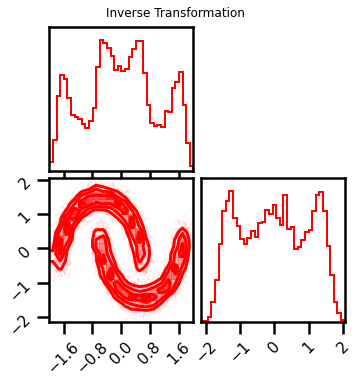

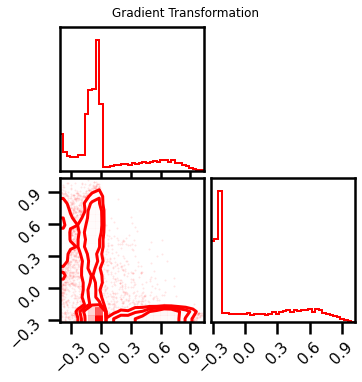

In [19]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l3_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

## Multiple Layers

So it's very evident that a single RBIG block isn't enough. We need multiple layers. So all we need to do is loop through the `init_` methods until we are satisfied. Then once we're done, we can create another chain and check how good is our transformation.

In [20]:
%%time

import itertools

itercount = itertools.count(-1)

n_layers = 20
i_layer = 0

# initialize rbig block
init_functions = [
    init_hist_f,
    init_icdf_f,
    init_pca_f
]

# initialize RBIG Init Block
rbig_block_init = RBIGBlockInit(init_functions=init_functions)

# initialize list of bijectors
bijectors = list()

# initialize transform
X_g = X.copy()

plot_steps = False

while next(itercount) < n_layers:
    
    # fit RBIG block
    X_g, ibijector = rbig_block_init.forward_and_params(X_g)
    
    if plot_steps:
        fig = corner.corner(X_g, color="blue", hist_bin_factor=2)
    
    # append bijectors 
    bijectors += ibijector

CPU times: user 1min 46s, sys: 16.3 s, total: 2min 3s
Wall time: 14.7 s


#### Check Transformation

Now let's check the Gaussianized data to see how well we did.

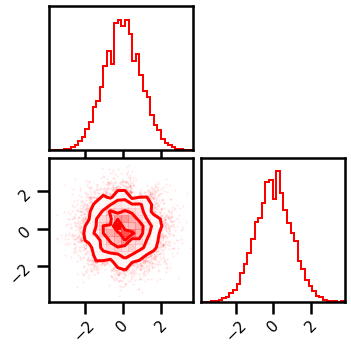

In [21]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

This looks pretty good. So let's see how good the inverse transformation. Again, we create a `bijectorchain` which will loop through all of the transformations



In [22]:
# create rbig_model
rbig_model = BijectorChain(bijectors=bijectors)

In [23]:
%%time
# forward with bijector
X_g_ = rbig_model.forward(X)

chex.assert_tree_all_close(X_g_, X_g, rtol=1e-4)

# inverse transformation
X_approx = rbig_model.inverse(X_g)

chex.assert_tree_all_close(X_approx, X, rtol=1e-2)

# gradient transformation
X_g_ldj = rbig_model.forward_log_det_jacobian(X)

# forward and gradient transformation
X_g__, X_g_ldj_ = rbig_model.forward_and_log_det(X)

chex.assert_tree_all_close(X_g__, X_g_)
chex.assert_tree_all_close(X_g_ldj, X_g_ldj_)

CPU times: user 10.5 s, sys: 635 ms, total: 11.1 s
Wall time: 8.89 s


Text(0.5, 0.98, 'Gradient Transformation')

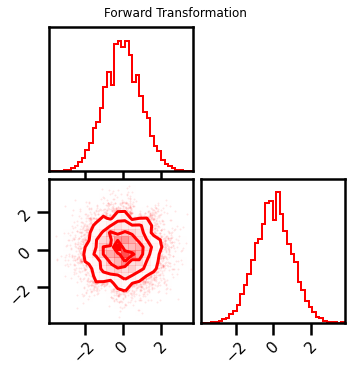

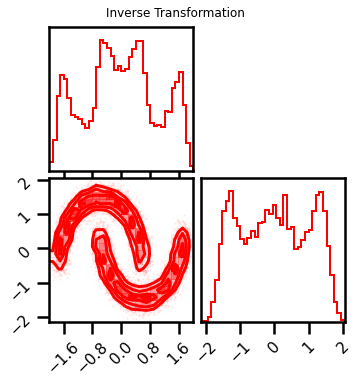

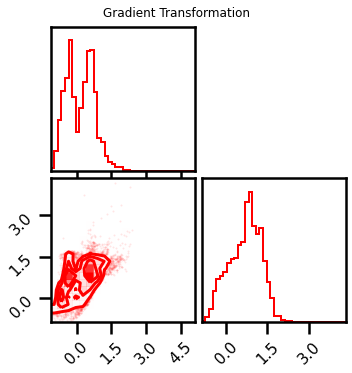

In [24]:
# plot Transformations
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_g_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

## Gaussianization Flow

The bijector chains allow us to do some extra things like density estimation or sampling. So we can also use the `GaussianizationFlow` class which is exactly like the `BijectorChain` class but with some additional benefits like calculating log probabilities. This may seem very redundant for the iterative method, but it is very helpful for fully parameterized Gaussianization; i.e. the end result is the same but the way to find the parameters are different.

In [25]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# initialize base distribution
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

# initialize flow model
rbig_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

### Density Estimation

Here we will do an example of density estimation. In this example, 

So here we will do an example of density estimation.
The same pythn code below is equivalent.

```python
# propagate through the chain
X_g_grid, X_ldj_grid = rbig_model.forward_and_log_det(xyinput)

# calculate log prob
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

latent_prob = base_dist.log_prob(X_g_grid)

# calculate log probability
X_log_prob = latent_prob.sum(axis=1) + X_ldj_grid.sum(axis=1)
```

However, using the `score_samples` method is a lot more convenient.

In [26]:
%%time
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

CPU times: user 6.33 s, sys: 349 ms, total: 6.68 s
Wall time: 4.44 s


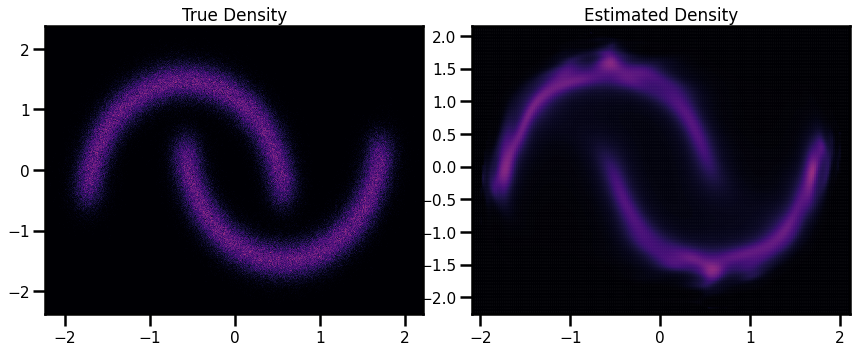

In [27]:
# Original Density
from matplotlib import cm

n_samples = 1_000_000
n_features = 2
ds = PlaneDataset(n_samples=n_samples, seed=42)
X_plot = ds[:]
X_plot = scaler.transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Score (Negative Log-Likelihood)


In [28]:
nll = rbig_model.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 1.9346


### Sampling

This is another useful application.

In [29]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 5.97 s, sys: 278 ms, total: 6.25 s
Wall time: 2.81 s


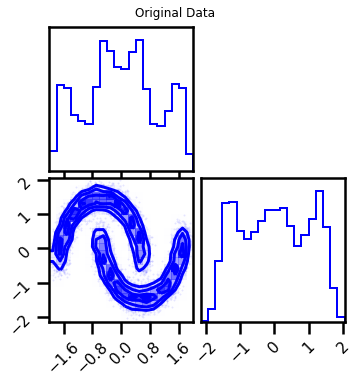

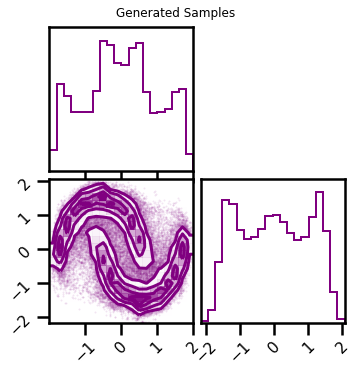

In [30]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Better Training

So we assumed that there would be $20$ layers necessary in order to train the model. But how do we know that it's the best model? This would require some *stopping criteria* instead of just an ad-hoc procedure. 

In RBIG, we use the **information reduction** loss which essentially checks how much information content is being removed with each iteration. We are effectively creating a more and more independent distribution with every marginal Gaussianization + rotation. So naturally, we can simply check how much the information is being reduced between iterations. If there are no changes, we can stop.

#### Loss Function

We can initialize the info loss function here.

In [31]:
from rbig_jax.losses import init_info_loss

# define loss parameters
max_layers = 1_000
zero_tolerance = 60
p = 0.25
base = 2
jitted = True

# initialize info loss function
loss = init_info_loss(
    n_samples=X.shape[0],
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    jitted=jitted,
)

#### Training

In [32]:
from rbig_jax.training.iterative import train_info_loss_model

# define training params
verbose = True
n_layers_remove = 50
interval = 10

# run iterative training
X_g, rbig_model_info = train_info_loss_model(
    X=X,
    rbig_block_init=rbig_block_init,
    loss=loss,
    verbose=verbose,
    interval=interval,
    n_layers_remove=n_layers_remove,
)

Layer 10 - Cum. Info Reduction: 1.767 - Elapsed Time: 8.7526 secs
Layer 20 - Cum. Info Reduction: 1.814 - Elapsed Time: 15.4133 secs
Layer 30 - Cum. Info Reduction: 1.814 - Elapsed Time: 22.0649 secs
Layer 40 - Cum. Info Reduction: 1.820 - Elapsed Time: 28.7050 secs
Layer 50 - Cum. Info Reduction: 1.824 - Elapsed Time: 35.4371 secs
Layer 60 - Cum. Info Reduction: 1.824 - Elapsed Time: 42.1669 secs
Layer 70 - Cum. Info Reduction: 1.824 - Elapsed Time: 48.8317 secs
Layer 80 - Cum. Info Reduction: 1.824 - Elapsed Time: 55.5498 secs
Layer 90 - Cum. Info Reduction: 1.824 - Elapsed Time: 62.1278 secs
Layer 100 - Cum. Info Reduction: 1.824 - Elapsed Time: 68.8128 secs
Converged at Layer: 101
Final Number of layers: 51 (Blocks: 17)
Total Time: 69.5398 secs


#### Information Reduction Evolution

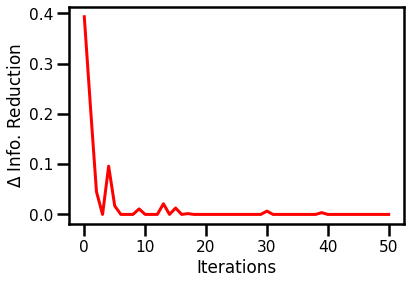

In [33]:
fig, ax = plt.subplots()
ax.plot(rbig_model_info.info_loss, color="red")
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [34]:
nll = rbig_model_info.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 1.9089


#### Density Estimation (Revisited)

In [35]:
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model_info.score_samples(xyinput)

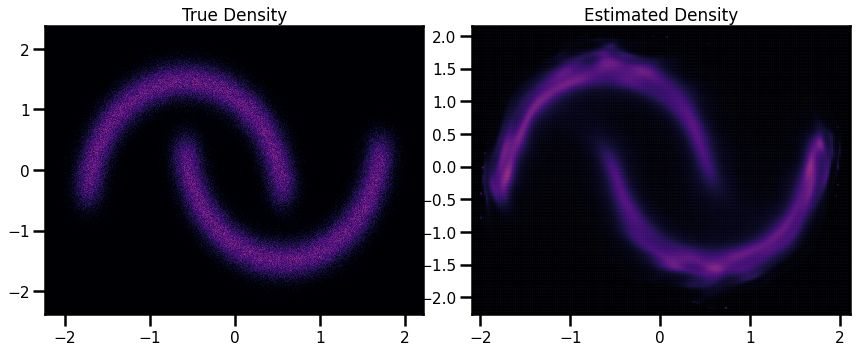

In [36]:
# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

#### Sampling Revisited

In [37]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model_info.sample(seed=seed, n_samples=n_samples)

CPU times: user 10.9 s, sys: 592 ms, total: 11.5 s
Wall time: 2.99 s


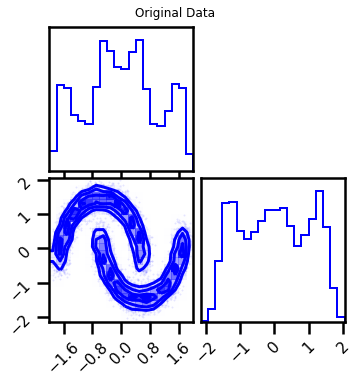

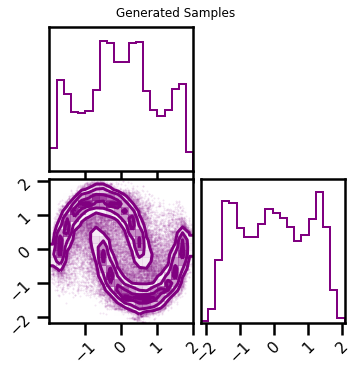

In [38]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [39]:
import pickle

# # save the blocks
# with open("rbig_block.pickle", "wb") as f:
#     pickle.dump(rbig_block, f)

# # save the bijectors
# with open("bijectors.pickle", "wb") as f:
#     pickle.dump(bijectors, f)

# save the full model
with open("rbig_model.pickle", "wb") as f:
    pickle.dump(rbig_model_info, f)

#### Loading

Loading is straight forward!

In [40]:
with open("rbig_model.pickle", "rb") as f:
    rbig_model_loaded = pickle.load(f)

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [41]:
# nll for the old model
nll = rbig_model_info.score(X)
print(f"Negative Log-Likelihood: {nll:.4f}")

# nll for the loaded model
nll = rbig_model_loaded.score(X)
print(f"Negative Log-Likelihood: {nll:.4f}")

Negative Log-Likelihood: 1.9089
Negative Log-Likelihood: 1.9089
